In [25]:
%matplotlib inline
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import pandas as pd
import corner
import astropy
import astropy.units as u

In [26]:
columns=['name','redshift','distance_mod','DM_err','SN_prob']
rawdat=pd.read_csv('SCPUnion2.1_mu_vs_z.txt', sep='\s',names=columns, header=5, engine='python')

In [27]:
data=np.sort(rawdat.T, axis=0)
zs = rawdat.redshift
mm = rawdat.distance_mod
dm = rawdat.DM_err

In [28]:
from astropy.cosmology import LambdaCDM

In [29]:
def DM(z,H0,Om,Ode):
    cosmo = LambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ode0=0.7)
    DL=cosmo.luminosity_distance(z)
    mag=5*np.log10((DL/(10*u.pc)).decompose())
    return mag

In [30]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [31]:
p = lmfit.Parameters()
p.add_many(('Om',0.3),('H0',70.0),('Ode',0.7))

def residual(p):
    v = p.valuesdict()
    return (DM(zs,v['H0'],v['Om'],v['Ode'])-mm)/dm

In [35]:
print p

Parameters([('Om', <Parameter 'Om', 0.3, bounds=[-inf:inf]>), ('H0', <Parameter 'H0', 70.0, bounds=[-inf:inf]>), ('Ode', <Parameter 'Ode', 0.7, bounds=[-inf:inf]>)])


In [32]:
mi = lmfit.minimize(residual, p, method='nelder', nan_policy='omit')

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 84
    # data points      = 579
    # variables        = 3
    chi-square         = 564.653902
    reduced chi-square = 0.98030191
    Akaike info crit   = -8.52681917
    Bayesian info crit = 4.55708826
[[Variables]]
    Om:   0.30000000 (init = 0.3)
    H0:   70.0000000 (init = 70)
    Ode:  0.70000000 (init = 0.7)


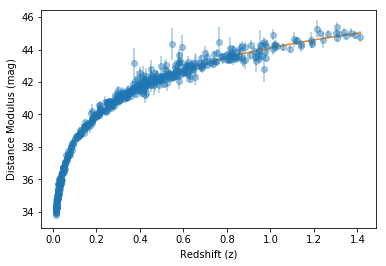

In [33]:
s = (zs.sort_values()).index
plt.errorbar(zs[s],mm[s],yerr=dm[s],fmt='o',alpha=0.4)
bestOm = mi.params.valuesdict()['Om']
bestH0 = mi.params.valuesdict()['H0']
bestOde =mi.params.valuesdict()['Ode']
plt.plot(zs[s],DM(zs[s],bestH0,bestOm,bestOde))
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mag)')
lmfit.report_fit(mi)

In [34]:
res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=600, steps=2000, thin=1,
                         params=mi.params, is_weighted=True)

ValueError: At least one parameter value was infinite.

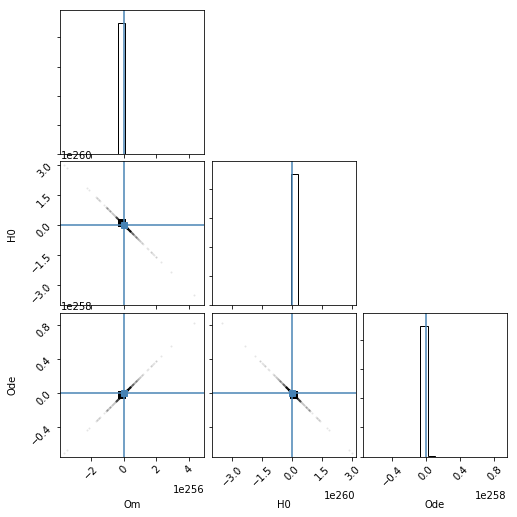

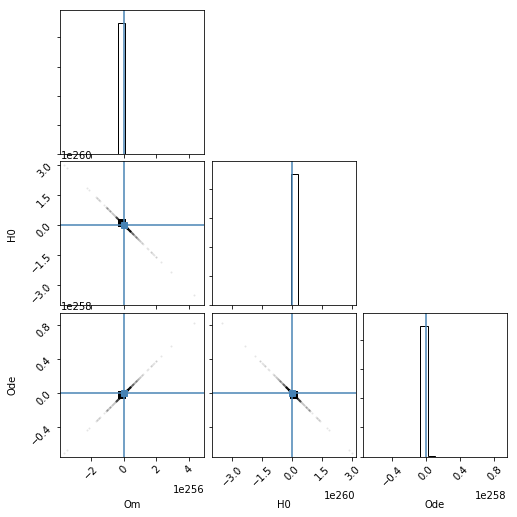

In [23]:
corner.corner(res.flatchain,labels=mi.var_names, truths=list(mi.params.valuesdict().values()))